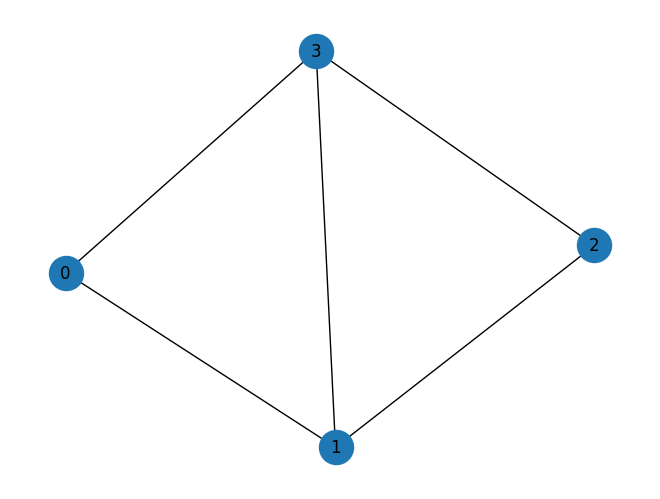

In [104]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 4

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 0, 1.0), (1, 3, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# convert graph problem to QUBO in the form of (x^T)(Q)(x) where x represents nodes in the graph (length n vector), Q represents the edges between nodes (nxn mat)
Q = np.zeros(shape=(n,n)) #Q[i,j]
np.fill_diagonal(Q, -2)
for edge in edge_list:
    u = edge[0]
    v = edge[1]
    assert u != v
    Q[u,v] = 1
    Q[v,u] = 1

# convert QUBO problem to hamiltonian, starting with a vector b denoting offset when changing from x:{0,1} to z:{-1,1}
b = np.zeros(shape=(n))
for i in range(n):
    summation = 0
    for j in range(n):
        summation -= Q[i,j] + Q[j,i]
    b[i] = summation

# list of hamiltonian terms
pauli_list = []
for i in range(n):
    for j in range(n):
        if Q[i,j] == 0:
            continue
        pauli_gates = ["I"] * n
        pauli_gates[i] = "Z"
        pauli_gates[j] = "Z"
        pauli_list.append(("".join(pauli_gates)[::-1], Q[i,j]))
    pauli_gates = ["I"] * n
    pauli_gates[i] = "Z"
    pauli_list.append(("".join(pauli_gates)[::-1], b[i]))

pauli_dict = {}

for pauli in pauli_list:
    gates, weight = pauli
    if weight == 0:
        continue
    if gates not in pauli_dict:
        pauli_dict[gates] = weight
    else:
        pauli_dict[gates] += weight
    
pauli_list = []

for gates, weight in pauli_dict.items():
    pauli_list.append((gates, weight))

pauli_list

cost_hamiltonian = SparsePauliOp.from_list(pauli_list)
cost_hamiltonian


SparsePauliOp(['IIIZ', 'IIZZ', 'ZIIZ', 'IIIZ', 'IIZZ', 'IIZI', 'IZZI', 'ZIZI', 'IIZI', 'IZZI', 'IZII', 'ZZII', 'IZII', 'ZIIZ', 'ZIZI', 'ZZII', 'ZIII', 'ZIII'],
              coeffs=[-2.+0.j,  1.+0.j,  1.+0.j,  0.+0.j,  1.+0.j, -2.+0.j,  1.+0.j,  1.+0.j,
 -2.+0.j,  1.+0.j, -2.+0.j,  1.+0.j,  0.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,
 -2.+0.j, -2.+0.j])

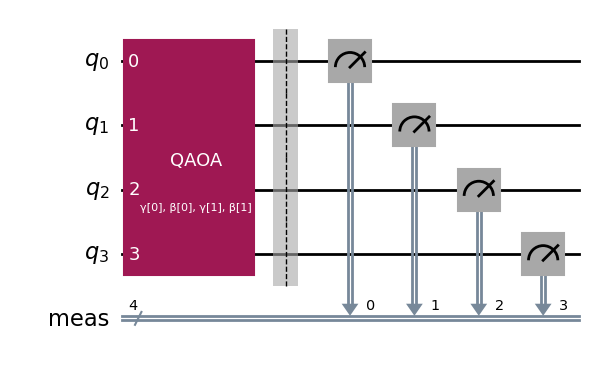

In [106]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

QasmSimulator('qasm_simulator')


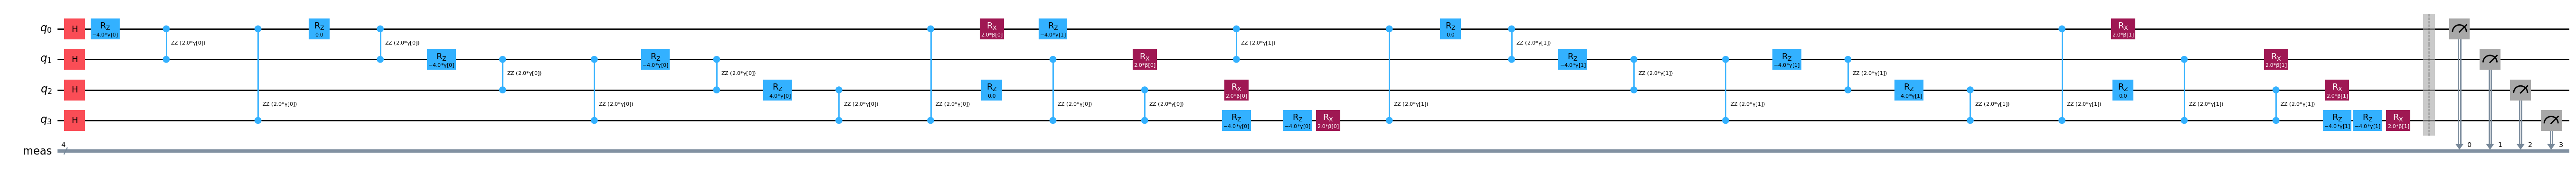

In [107]:
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
backend = backend = Aer.get_backend('qasm_simulator')
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [108]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [109]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.072927072927072
       x: [ 3.309e+00  2.612e+00  3.895e+00  1.510e+00]
    nfev: 32
   maxcv: 0.0


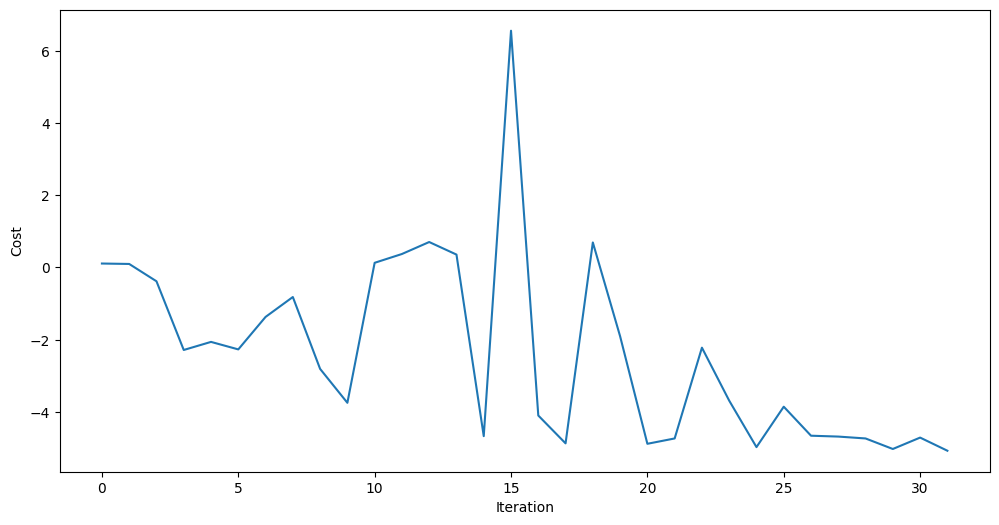

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

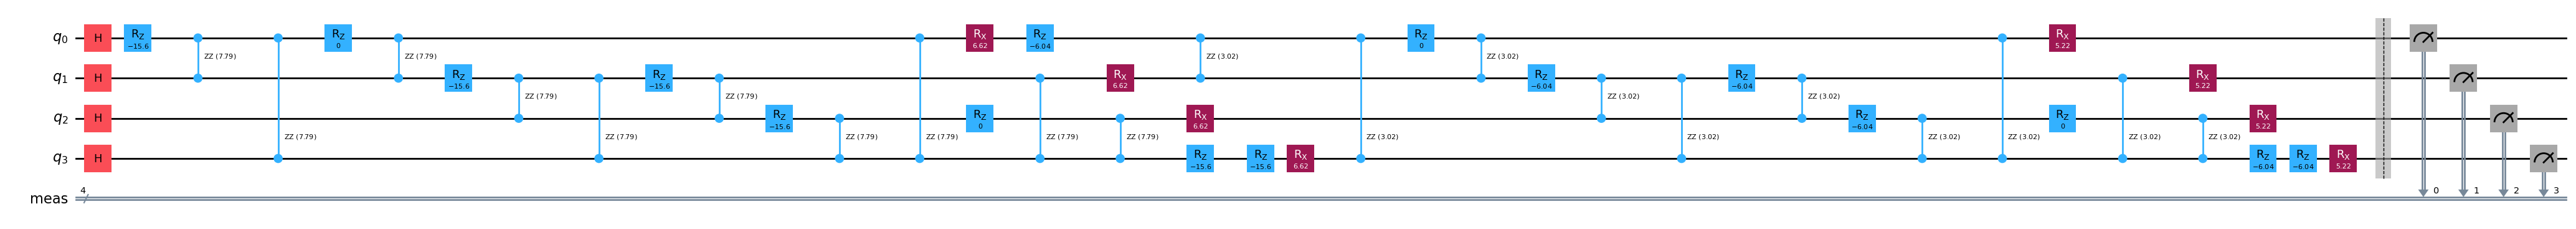

In [111]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [112]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{8: 0.1396, 0: 0.1116, 9: 0.0415, 10: 0.0371, 4: 0.1231, 5: 0.1401, 2: 0.1425, 1: 0.1201, 12: 0.041, 3: 0.0378, 6: 0.0433, 15: 0.0081, 7: 0.0047, 13: 0.0064, 11: 0.0018, 14: 0.0013}


In [113]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 0]


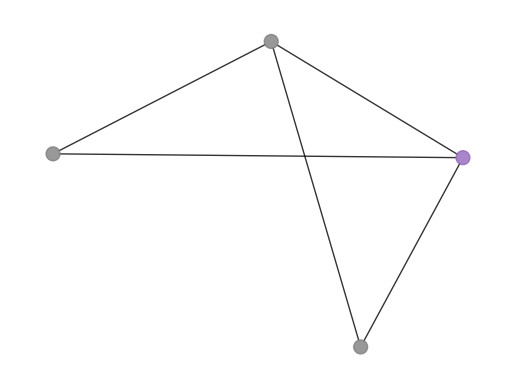

In [114]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

plot_result(graph, most_likely_bitstring)